In [7]:
import pandas as pd
import pandahouse as ph
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
import swifter
from scipy import stats
%matplotlib inline

# Анализ результатов A/B-теста

## Контекст эксперимента

С **2 по 8 мая 2025 года** проводился A/B-тест, организованный совместно с командой дата сайентистов.  
В тесте участвовали две группы:

| Группа | Описание |
|--------|----------|
| **Группа 1 (control)** | Стандартная версия рекомендаций |
| **Группа 2 (treatment)** | Новый алгоритм рекомендаций |

**Цель теста:** проверить гипотезу о том, что новый алгоритм повысит **CTR** (Click-through Rate), то есть долю лайков к просмотрам.

---

## Ваша задача

Проанализируем данные A/B-теста и ответим на ключевые вопросы:

### 1. Сравнение CTR между группами

Используем следующие методы:
- `t-тест`
- `Тест Манна-Уитни`
- `Пуассоновский бутстреп`
- `t-тест на сглаженном CTR (α=5)`
- `t-тест и тест Манна-Уитни поверх бакетного преобразования`

### 2. Исследование распределений

- Построим графики: гистограммы, boxplot, KDE.
- Оценим наличие выбросов, асимметрии и других особенностей распределения CTR в обеих группах.

### 3. Объяснение результатов

- Почему одни тесты показывают значимость, а другие — нет?
- Как могло повлиять наличие выбросов или нестандартное распределение?
- Что может объяснять различия (или их отсутствие) между группами?

---

In [8]:
# 2025-05-02 по 2025-05-08
# группы 1 и 2

In [8]:
#Подключаемся с clickhouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250520'
}

q = """
SELECT 
    user_id,
    exp_group,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) BETWEEN '2025-05-02' AND '2025-05-08'
  AND exp_group IN (1, 2)
GROUP BY user_id, exp_group
"""

# Получаем данные
df = ph.read_clickhouse(q, connection=connection)

In [9]:
df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


In [55]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

0.405 означает, что среднее первой группы чуть выше среднего второй группы
pvalue указывает на то что в выборках нет сильного различия

In [56]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

pvalue очень маленькое. Это указывает на значимые различия в группах.
Т.е Т-тест отличий не выявил, а Манна-Уитни прокрасился.

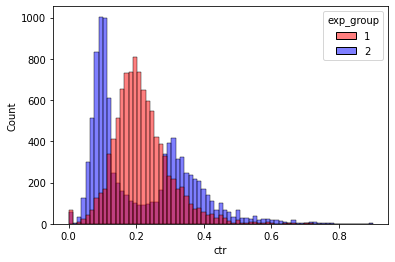

In [16]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Визуально можно заметить, что группа 2 имеет больше вариации в CTR, особенно на высоких значениях. Это может указывать на то, что новый алгоритм рекомендаций (используемый в группе 2) приводит к большим различиям в поведении пользователей:
Некоторые пользователи получают значительно лучший CTR.
Другие пользователи могут иметь даже худшие результаты.

## Почему стоит использовать сглаженный CTR

Одна из ключевых проблем при использовании классического CTR на уровне пользователя — это **высокая шумность метрики у пользователей с малым количеством просмотров**.

Например:
- У пользователя 3 просмотра и 1 лайк → CTR = 33%
- Но мы не можем быть уверены, что такой CTR репрезентативен для поведения этого пользователя в будущем.
- В то же время у пользователя с 200 просмотрами и 40 лайками (CTR = 20%) мы можем быть гораздо более уверенными в точности оценки.

### Идея сглаженного CTR

Для решения этой проблемы используется метод **сглаживания Лапласа**:

$$
\text{smoothed\_CTR}_u = \frac{\text{clicks}_u + \alpha \cdot \text{global\_CTR}}{\text{views}_u + \alpha}
$$

Где:
- $ \text{clicks}_u $ — количество лайков пользователя за период
- $ \text{views}_u $ — количество просмотров пользователя за период
- $ \text{global\_CTR} $ — общий CTR по группе (или всему трафику)
- $ \alpha $ — гиперпараметр, регулирующий силу сглаживания

---

### Как работает сглаживание?

Смысл сглаженного CTR в том, чтобы "подтянуть" значения CTR пользователей с малым числом просмотров к общегрупповому среднему:

| Количество просмотров | Поведение CTR |
|-----------------------|----------------|
| Мало (например, < 10) | Значение CTR близко к global_CTR |
| Средне (например, ~20) | Компромисс между индивидуальным и общим CTR |
| Много (например, > 100) | Значение CTR почти равно реальному кликам / просмотрам |

Это позволяет:
- Уменьшить влияние случайных выбросов от пользователей с низкой активностью.
- Получить более устойчивую метрику для анализа A/B-тестов.

---

### Преимущества и ограничения

#### Преимущества:
- Уменьшение влияния шума от пользователей с малой активностью.
- Более устойчивые результаты тестов.
- Возможность сравнения пользователей с разным уровнем активности.

#### Ограничения:
- Нет строгих теоретических гарантий, что сглаженный CTR будет коррелировать с **реальным поведением** пользователей.
- Выбор значения $ \alpha $ может влиять на результаты тестирования.
- Не все команды принимают этот подход из-за его эвристической природы.

---

### Пример интерпретации

> Представьте, что вы хотите понять, насколько пользователь действительно предпочитает лайкать посты.  
> У одного пользователя всего 3 просмотра и 1 лайк → CTR = 33%, но это слишком нестабильно.  
> У другого пользователя 200 просмотров и 40 лайков → CTR = 20%, и мы можем быть уверены в этом значении.  

Сглаженный CTR помогает нам:
- **Не перегружаться** на шумные данные от малоактивных пользователей.
- **Учитывать** глобальную картину при анализе новых или малоданных пользователей.

---

### Настройка α

Выбор параметра $ \alpha $ зависит от данных и продукта. Например:
- Если $ \alpha = 5 $, это значит, что мы добавляем "фиктивные" клики и просмотры, эквивалентные 5 просмотрам со средним CTR.

Ты можешь подбирать $ \alpha $ через:
- Графики плотности и распределений
- Сравнение до и после сглаживания
- Анализ чувствительности теста

---

### Заключение

Сглаженный CTR — полезный инструмент в анализе A/B-тестов, особенно когда много пользователей имеет мало взаимодействий с продуктом.

Хотя у него нет строгой математической гарантии, на практике он:
- Снижает дисперсию
- Улучшает работу статистических тестов (t-тест, например)
- Позволяет сравнивать пользователей с разной степенью активности

Если вы работаете с метриками, чувствительными к шуму — попробуйте сглаженный CTR. Он может помочь получить более точные и устойчивые выводы.

In [62]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [63]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

In [64]:
global_ctr_1, global_ctr_2

(0.2096041628394293, 0.20025051027061783)

In [ ]:
#глобальный стр в первой (контрольной) группе больше.

<Axes: xlabel='ctr', ylabel='Count'>

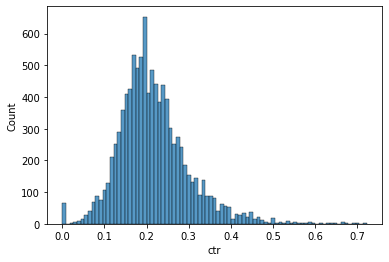

In [65]:
group1 = df[df.exp_group == 1].copy()
sns.histplot(group1.ctr, 
             kde = False)

<Axes: xlabel='ctr', ylabel='Count'>

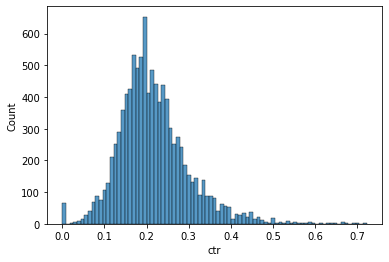

In [66]:
group2 = df[df.exp_group == 2].copy()
sns.histplot(group1.ctr, 
             kde = False)

In [59]:
#такое чувство что они вообще абсолютно одинаковы

<Axes: xlabel='smothed_ctr', ylabel='Count'>

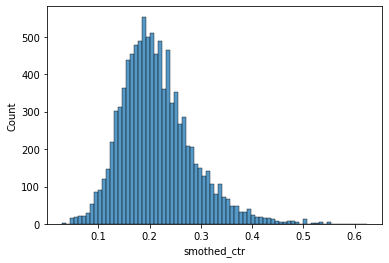

In [67]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.histplot(group1.smothed_ctr, 
             kde = False)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

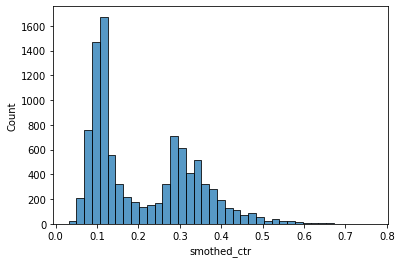

In [68]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.histplot(group2.smothed_ctr, 
             kde = False)

In [69]:
stats.ttest_ind(group1['smothed_ctr'],
                group2['smothed_ctr'],
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

На сглаженном CTR Т-тест практически показал значимые различия, но все еще не достаточные для приянтие.

## Пуассоновский бутстреп для анализа разницы в CTR

Пуассоновский бутстреп — это метод оценки статистической значимости, особенно полезный при работе с метриками, зависящими от пользовательской активности, такими как **CTR (Click-through Rate)**.

Он позволяет учитывать **разную степень вклада каждого пользователя** в общую метрику и снижает влияние шума от малоданных пользователей.

---

### Как работает алгоритм:

#### Шаг 1: Подготовка данных
- У нас есть две группы: **A (control)** и **B (treatment)**.
- Для каждого пользователя известны:
  - `views` — количество просмотров
  - `clicks` — количество лайков

---

#### Шаг 2: Генерация псевдовыборок

Для каждой итерации бутстрепа:

1. **Группа A**
   - Генерируем веса `weights_1` для каждого пользователя из распределения **Пуассона(λ=1)**.
     Это означает, что каждый пользователь случайным образом "входит" в псевдовыборку несколько раз (или не входит совсем).
   - Считаем "глобальный CTR" для псевдовыборки группы A:

   $$
   \text{global\_CTR}_A = \frac{\sum(\text{clicks}_A \cdot \text{weights}_1)}{\sum(\text{views}_A \cdot \text{weights}_1)}
   $$

2. **Группа B**
   - Аналогично генерируем веса `weights_2` для пользователей из группы B.
   - Считаем "глобальный CTR" для псевдовыборки группы B:

   $$
   \text{global\_CTR}_B = \frac{\sum(\text{clicks}_B \cdot \text{weights}_2)}{\sum(\text{views}_B \cdot \text{weights}_2)}
   $$

3. **Считаем разницу между группами:**

   $$
   \text{diff} = \text{global\_CTR}_A - \text{global\_CTR}_B
   $$

   Эту разницу сохраняем в список результатов.

---

### Шаг 3: Повторение

Повторяем шаги 2–3 **многократно** (например, **2000 раз**) для построения **распределения разницы CTR между группами**.

---

### Что мы получаем на выходе?

После всех итераций у нас будет **эмпирическое распределение разницы CTR** между группами. На основе этого распределения можно:

- Оценить **среднюю разницу**
- Найти **доверительный интервал**
- Определить, является ли разница **статистически значимой**

---

### Преимущества пуассоновского бутстрепа:

- Учитывает **индивидуальные особенности пользователей** (их просмотры и клики).
- Не предполагает нормальность исходных данных.
- Хорошо работает с **метриками, зависящими от числа событий** (например, CTR, CR и т.д.).

---

### Почему именно Пуассон?

Распределение Пуассона с λ=1 идеально подходит для бутстрепа:
- Каждый пользователь может быть взят **0, 1, 2 и более раз**.
- Это имитирует **случайную выборку** и сохраняет естественную вариацию в данных.
- Такой подход сохраняет **взвешенность** и корректно учитывает повторные включения.

---

<Axes: ylabel='Count'>

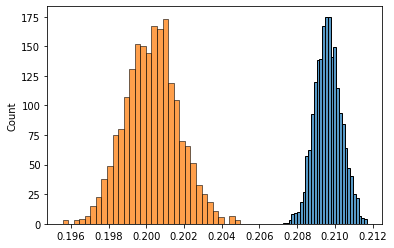

In [47]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20250520'
}

q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2025-05-02' and '2025-05-08'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = ph.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

<Axes: ylabel='Count'>

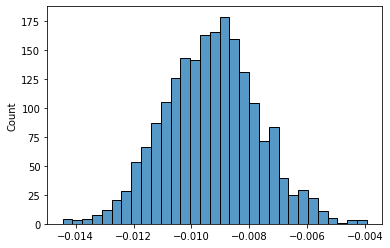

In [48]:
#Разница между глобальными CTR

sns.histplot(ctr2 - ctr1)

In [ ]:
#значения отрицательны, т.е контроль больше таргета

## Бакетное преобразование: как и зачем его использовать

Бакетное преобразование — популярный метод анализа данных в A/B-тестировании. Оно помогает уменьшить влияние шума и повысить стабильность статистических тестов, особенно когда данные имеют сильные выбросы или неравномерное распределение.

---

### Основная идея

1. **Разделение пользователей на бакеты**
   - Все пользователи равномерно разбиваются на **N бакетов** (обычно 50 или 100).
   - Каждый пользователь попадает **только в один бакет**.
   - Разбиение проводится с помощью **солёного хэширования**, чтобы обеспечить **случайность и воспроизводимость**.

2. **Агрегация метрик по бакетам**
   - В каждом бакете рассчитывается агрегированная метрика (например, средний CTR, медиана просмотров и т.д.).
   - Таким образом, каждый бакет становится своего рода **«метапользователем»**.

3. **Анализ по бакетам**
   - Вместо анализа по отдельным пользователям мы работаем с агрегированными значениями по бакетам.
   - Например, при 50 бакетах получаем **по 50 значений** на группу, и уже их сравниваем.

---

### Пример

> Допустим, у нас есть 100 000 пользователей в группе A и столько же в группе B.  
> Мы делим их по 2000 пользователей на бакет — получаем по **50 бакетов** на группу.  
> В каждом бакете считаем **средний CTR**.  
> Теперь у нас есть две выборки по 50 числам, и мы можем применить к ним **t-тест** или **тест Манна-Уитни**.

---

### 📌 Почему это работает?

Бакетное преобразование напоминает **непараметрический бутстреп**, но делает это **без генерации новых данных**, а на основе уже имеющихся.

- Каждый бакет — это **срез данных**, который отражает поведение части пользователей.
- Агрегация по бакетам **снижает дисперсию** и делает распределение более нормальным.
- Это улучшает работу классических тестов, таких как **t-тест**, и снижает вероятность ложных срабатываний.

---

### 🧠 Преимущества бакетного преобразования

- **Уменьшение влияния выбросов** — за счёт агрегации.
- **Стабильность метрик** — бакеты делают распределение более нормальным.
- **Воспроизводимость** — можно использовать одинаковую систему сплитования для разных тестов.
- **Гибкость** — можно считать не только среднее, но и медиану, дисперсию, квантили и т.д.

---

### 🧪 Как применить на практике

1. Разбей пользователей на **N бакетов** (например, 50).
2. Для каждого бакета посчитай нужную метрику (например, средний CTR).
3. Примени статистический тест:
   - `t-тест`, если распределение близко к нормальному.
   - `тест Манна-Уитни`, если распределение сильно скошено или содержит выбросы.

---

### ✅ Пример вывода

> Бакетное преобразование позволяет снизить влияние шума и выбросов на результаты A/B-теста.  
> Мы разбиваем пользователей на 50 бакетов, считаем средний CTR по каждому и проводим сравнение между группами.  
> Такой подход делает тестирование более устойчивым и позволяет использовать классические тесты, даже если исходные данные далеки от нормальности.

---

### 💡 Советы по реализации

- Используй `xxHash64(user_id || 'salt') % N` для равномерного разбиения.
- Проверь, чтобы пользователи были распределены **равномерно** по бакетам.
- Для анализа используй среднее или медиану CTR по бакетам.
- Поверх бакетов можно запускать **t-тест** или **Манна-Уитни**.

---

### 🧮 Пример кода (ClickHouse)

```sql
-- Пример разбиения на 50 бакетов
SELECT 
    xxHash64(toString(user_id) || 'my_salt') % 50 AS bucket,
    AVG(clicks / views) AS avg_ctr
FROM dataset
WHERE group = 'A'
GROUP BY bucket

In [50]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2025-05-02' and '2025-05-08'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = ph.read_clickhouse(q, connection=connection)

#тест Манна-Уитни видит отличие
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

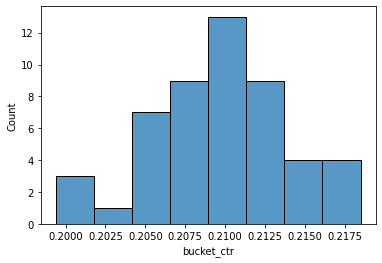

In [51]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<Axes: xlabel='bucket_ctr', ylabel='Count'>

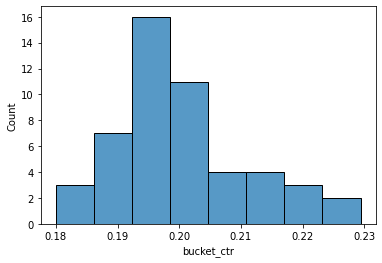

In [52]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)

In [72]:
#Ответ очевиден, не будем вводить новые алгоритм
